## Lesson-06 Recurrent Neural Networks 循环神经网络的原理及应用

循环神经网络是我们常用的一个网络模型，这个网络能够处理例如字符串，时间序列等问题。因为模型对序列问题的优势，RNN模型已经成为了自然语言处理问题的常见方法。

在本课程的作业中，我们将完成三个任务：

0. 基于任务驱动，实际感受并能够初步使用pytorch；
1. 使用RNN模型进行名字的国籍分类；(这个程序主要是参考的Pytorch文档)

RNN也可以用于金融数据的预测，例如:
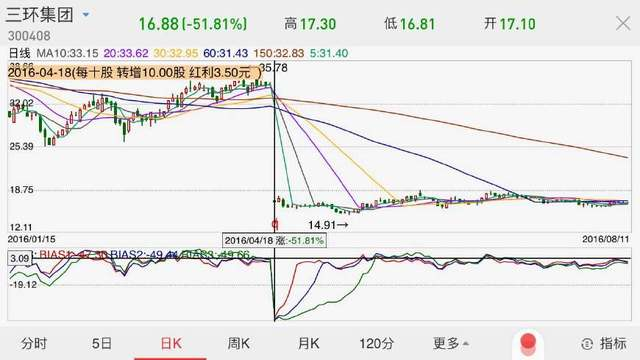

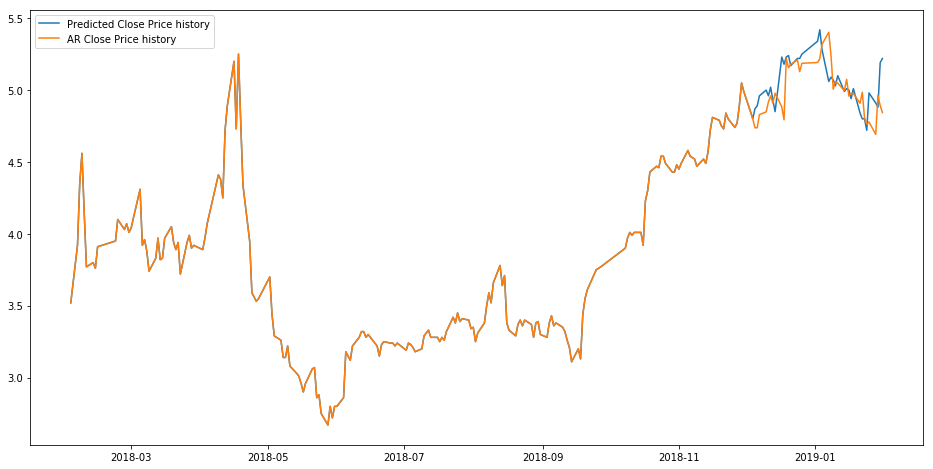

上图中蓝色的部分就是预测值， 关于RNN模型对金融数据的预测，我们只会会增加专门的研讨课程，给大家讲解

我们今天带给大家的是使用RNN进行名字的国籍分类:

## 1. 使用RNN模型进行名字的国籍分类

首先，我们下载数据: 将这个数据置于和我们jupyter notebook位置相同的地方

#### 1.1 我们利用通配符，打印出所有的文件

In [2]:
from io import open
import glob
import os
import matplotlib.pyplot as plt


def find_files(path): return glob.glob(path)

print(find_files('data/names/*.txt'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


### 1.2 名字里边包含不少非Ascii码，为了简便问题，我们将他们转化为Ascii码

In [3]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_2_Ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_2_Ascii('Ślusàrski'))

Slusarski


### Step1.3 然后我们建立类别和对于的名字的dictionary对应

In [4]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_2_Ascii(line) for line in lines]

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [5]:
n_categories

18

In [6]:
category_lines['Chinese'][:10]

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao']

### 1.4 这一次我们使用pytorch, 来进行向量化

In [7]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_index('J'))

print(line_to_tensor('Jones').size())

35
torch.Size([5, 1, 57])


In [8]:
line_to_tensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

我们可以看到，是对名字里的每个字符做了 one-hot操作

### 1.5 然后，我们构建一个这样的RNN网络

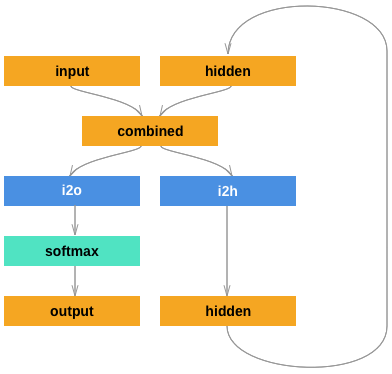

In [91]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [92]:
rnn = RNN(n_letters, n_hidden, n_categories)

### 1.6 运行一步RNN

为了运行这个rnn网络，我们需要给他一个input，然后再加上一个hidden state. 然后我们就能过获得一个output，这个output便是的是这个单词的属于每个国家的概率，和接下来的hidden state.

In [14]:
input = letter_to_tensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [15]:
input

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [16]:
output

tensor([[-2.9799, -2.8917, -2.8880, -2.8329, -2.9404, -2.7672, -2.9008, -2.9148,
         -2.9145, -2.9106, -2.9140, -2.9699, -2.8522, -2.7816, -2.9058, -2.9412,
         -2.8621, -2.8867]], grad_fn=<LogSoftmaxBackward>)

In [17]:
next_hidden

tensor([[-0.0046,  0.1339, -0.0280, -0.0185,  0.0850,  0.0672, -0.1007, -0.0820,
         -0.0078,  0.0141, -0.0795, -0.0527,  0.1071, -0.0531, -0.0814, -0.0230,
         -0.0320, -0.0075, -0.0117, -0.0116,  0.1299,  0.0295,  0.0321, -0.0235,
         -0.0087, -0.0189, -0.0432, -0.0241, -0.0082, -0.0442, -0.0418, -0.0210,
         -0.0354,  0.0230,  0.0512, -0.0353, -0.0472, -0.0203, -0.0172,  0.0295,
          0.0869, -0.0224, -0.0077, -0.0550,  0.0979,  0.0384,  0.0677,  0.0713,
          0.0272,  0.0794, -0.0191, -0.0243, -0.0684, -0.0703, -0.0355,  0.0247,
         -0.0544,  0.0382, -0.0024, -0.0783,  0.0713,  0.0301, -0.1134, -0.0081,
          0.0050,  0.0422, -0.0470,  0.0572, -0.0492,  0.0731,  0.0180, -0.0450,
         -0.0612, -0.0771, -0.0420, -0.0456,  0.0072,  0.0175,  0.0269, -0.0458,
         -0.0418, -0.0227,  0.0785,  0.0587, -0.0028,  0.0270,  0.1058,  0.0194,
          0.0617,  0.0947,  0.0569,  0.0230, -0.0222,  0.0322,  0.0276, -0.0474,
         -0.0046, -0.0783,  

然后，我们可以使用 line_to_tensor, 把一句话直接变成 tensor

In [51]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9799, -2.8917, -2.8880, -2.8329, -2.9404, -2.7672, -2.9008, -2.9148,
         -2.9145, -2.9106, -2.9140, -2.9699, -2.8522, -2.7816, -2.9058, -2.9412,
         -2.8621, -2.8867]], grad_fn=<LogSoftmaxBackward>)


这个output，就是基于目前的RNN参数，预测出来的国籍概率分布。显然是不对的，因为里边的参数都是随机的。

### 1.7 更好的观察结果

为了能够更好的看到我们的训练结果，我们需要把输出的tensor变成我们能看懂的国籍

In [52]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i



对于刚刚产生的output，我们使用这个函数

In [53]:
print(category_from_output(output))

('French', 5)


### 1.8 随机生成训练数据

In [54]:
import random

def sample(l):
    return l[random.randint(0, len(l) - 1)]

def sample_trainning():
    category = sample(all_categories)
    line = sample(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = sample_trainning()
    print('category =', category, '/ line =', line)

category = Polish / line = Kowalczyk
category = Spanish / line = Petit
category = Dutch / line = Klerx
category = English / line = Deacon
category = Chinese / line = Yep
category = Greek / line = Karameros
category = Arabic / line = Essa
category = Polish / line = Brzezicki
category = Czech / line = Kozumplikova
category = Vietnamese / line = Ma


### 因为我们这个模型需要 softmax 来获得每个类别，所以我们使用cross-entropy作为Loss函数

In [55]:
criterion = nn.CrossEntropyLoss()

In [65]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [93]:
import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (0m 0s) 3.0355 Tsoumada / Japanese ✗ (Greek)
1000 10% (0m 1s) 2.7085 Agnelli / Italian ✓
1500 15% (0m 2s) 2.8132 An / Irish ✗ (Vietnamese)
2000 20% (0m 3s) 2.4788 Zhelyabov / Russian ✓
2500 25% (0m 4s) 2.8103 Kabulahin / Scottish ✗ (Russian)
3000 30% (0m 5s) 2.6752 Dang / Vietnamese ✓
3500 35% (0m 5s) 2.7640 O'Hannigain / Scottish ✗ (Irish)
4000 40% (0m 6s) 2.8141 Portoghese / English ✗ (Italian)
4500 45% (0m 7s) 2.6999 Botros / Greek ✗ (Arabic)
5000 50% (0m 8s) 2.6965 Ramecker / German ✗ (Dutch)
5500 55% (0m 8s) 3.0033 Mar'In / Irish ✗ (Russian)
6000 60% (0m 9s) 2.5281 Morcos / Portuguese ✗ (Arabic)
6500 65% (0m 10s) 2.5480 O'Gorman / Scottish ✗ (Irish)
7000 70% (0m 11s) 2.2133 Alfero / Spanish ✗ (Italian)
7500 75% (0m 12s) 2.9311 Hardy / Arabic ✗ (French)
8000 80% (0m 13s) 3.0671 Campos / Arabic ✗ (Spanish)
8500 85% (0m 13s) 1.5362 Wronski / Polish ✓
9000 90% (0m 14s) 1.0089 Huan / Chinese ✓
9500 95% (0m 15s) 2.0780 Tron / Korean ✗ (Vietnamese)
10000 100% (0m 16s) 2.4677 Grena

### 1.9 观察Loss的变化

In [94]:
all_losses

[2.891580357551575,
 2.886815459728241,
 2.8832087993621824,
 2.868968360424042,
 2.880379183292389,
 2.871341731548309,
 2.8591354584693907,
 2.8488731360435486,
 2.849225664138794,
 2.835862202644348,
 2.842148654460907,
 2.837037944793701,
 2.832544593811035,
 2.8414474606513975,
 2.837263989448547,
 2.80645770072937,
 2.82409307718277,
 2.8057355189323427,
 2.8155477452278137,
 2.7902112126350405,
 2.8058355116844176,
 2.7956420254707335,
 2.781797432899475,
 2.806478898525238,
 2.791347019672394,
 2.7659925484657286,
 2.729535617828369,
 2.7699120473861694,
 2.764366476535797,
 2.7679057478904725,
 2.752183656692505,
 2.7554935574531556,
 2.7508809924125672,
 2.716457574367523,
 2.7309282982349394,
 2.7487514877319335,
 2.707424511909485,
 2.699273495674133,
 2.6559285879135133,
 2.721900464296341,
 2.629286093711853,
 2.6209425282478334,
 2.6630596482753752,
 2.628989783525467,
 2.59163272857666,
 2.59559313416481,
 2.5810746997594833,
 2.505896351337433,
 2.628488448858261,
 2.5

In [95]:
%matplotlib inline

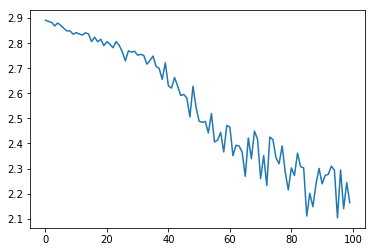

In [96]:
plt.plot(all_losses)

In [74]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-1.91) Russian
(-1.98) Polish
(-2.21) Czech

> Jackson
(-1.74) Russian
(-1.98) Irish
(-2.04) Scottish

> Satoshi
(-1.60) Italian
(-2.10) Polish
(-2.21) Japanese


## 代码练习

### 1. 尝试在我们的RNN模型中添加更多layers，然后观察Loss变化

In [97]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h1 = nn.Linear(input_size + hidden_size, hidden_size*2)
        self.i2h2 = nn.Linear(hidden_size*2, hidden_size)
        
        self.i2o1 = nn.Linear(input_size + hidden_size, hidden_size*2)
        self.i2o2 = nn.Linear(hidden_size*2, hidden_size)
        self.i2o3 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h1(combined)
        hidden = self.i2h2(hidden)
        
        output = self.i2o1(combined)
        output = self.i2o2(output)
        output = self.i2o3(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [98]:
n_hidden = 128

rnn = RNN(n_letters, n_hidden, n_categories)

In [99]:
import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


500 5% (0m 1s) 2.9647 Vargas / Korean ✗ (Spanish)
1000 10% (0m 3s) 2.8982 Vamvakidis / French ✗ (Greek)
1500 15% (0m 5s) 2.7196 Reiter / German ✓
2000 20% (0m 7s) 2.7693 Hall / Portuguese ✗ (German)
2500 25% (0m 9s) 2.8293 Comino / Portuguese ✗ (Greek)
3000 30% (0m 11s) 2.8852 Kruse / Japanese ✗ (German)
3500 35% (0m 13s) 2.8604 Macha / Japanese ✗ (Czech)
4000 40% (0m 14s) 2.8317 Wruck / Polish ✗ (German)
4500 45% (0m 16s) 2.7393 Yang / Chinese ✗ (Korean)
5000 50% (0m 18s) 2.8947 Lao / Portuguese ✗ (Chinese)
5500 55% (0m 20s) 2.9968 Scutese / German ✗ (Italian)
6000 60% (0m 22s) 2.7283 Paquet / Russian ✗ (French)
6500 65% (0m 24s) 2.4731 Cnaimhin / Russian ✗ (Irish)
7000 70% (0m 26s) 2.7024 Hassel / German ✗ (Dutch)
7500 75% (0m 28s) 2.5219 Montero / Japanese ✗ (Spanish)
8000 80% (0m 30s) 2.2850 Adamczyk / Czech ✗ (Polish)
8500 85% (0m 31s) 1.9707 Zhen / Chinese ✓
9000 90% (0m 33s) 2.6857 Widerlechner / German ✗ (Czech)
9500 95% (0m 35s) 3.9937 Opp / Chinese ✗ (Czech)
10000 100% (0m 37

In [102]:
all_losses

[2.8968552565574646,
 2.898627519607544,
 2.887608578205109,
 2.8906337308883665,
 2.878189134597778,
 2.884399218559265,
 2.8862398886680602,
 2.8649231386184693,
 2.8765755224227907,
 2.8902530121803283,
 2.8839508938789367,
 2.870135531425476,
 2.8781273317337037,
 2.86847252368927,
 2.864067003726959,
 2.8671057629585266,
 2.866393246650696,
 2.8481699562072755,
 2.878402307033539,
 2.8776393127441406,
 2.867922632694244,
 2.8588394355773925,
 2.8322154307365417,
 2.8447988414764405,
 2.8492628931999207,
 2.8530312895774843,
 2.826784596443176,
 2.8403748846054078,
 2.83102201461792,
 2.8398608016967772,
 2.824454455375671,
 2.8473670434951783,
 2.819123170375824,
 2.831504051685333,
 2.839632222652435,
 2.8023255109786986,
 2.830089864730835,
 2.8004078531265257,
 2.795289387702942,
 2.8122138595581054,
 2.7984330439567566,
 2.7509837317466737,
 2.774955942630768,
 2.7955941677093508,
 2.765681221485138,
 2.7580545592308043,
 2.7737377631664275,
 2.7784743773937226,
 2.74692605376

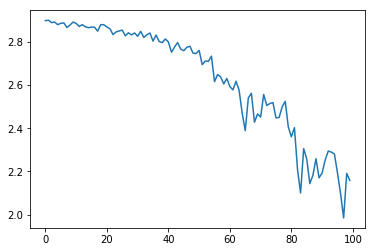

In [103]:
plt.plot(all_losses)

#### 添加更多layers之后, 在all_losses方面相差不大, 在all_losses变化图上看添加更多layers的all_losses在前期(epoch 60之前)的变化稳定, 到epoch = 60以后变化就很快。

In [106]:
#############添加更多的layers
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h1 = nn.Linear(input_size + hidden_size, hidden_size*3)
        self.i2h2 = nn.Linear(hidden_size*3, hidden_size*2)
        self.i2h3 = nn.Linear(hidden_size*2, hidden_size)
        
        self.i2o1 = nn.Linear(input_size + hidden_size, hidden_size*3)
        self.i2o2 = nn.Linear(hidden_size*3, hidden_size*2)
        self.i2o3 = nn.Linear(hidden_size*2, hidden_size)
        self.i2o4 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h1(combined)
        hidden = self.i2h2(hidden)
        hidden = self.i2h3(hidden)
        
        output = self.i2o1(combined)
        output = self.i2o2(output)
        output = self.i2o3(output)
        output = self.i2o4(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


In [107]:
n_hidden = 128

rnn = RNN(n_letters, n_hidden, n_categories)

In [108]:
import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


500 5% (0m 3s) 2.8051 Volk / Chinese ✗ (German)
1000 10% (0m 7s) 2.9570 Awad / Scottish ✗ (Arabic)
1500 15% (0m 11s) 2.8997 Stroggylis / French ✗ (Greek)
2000 20% (0m 14s) 2.9733 Demko / Chinese ✗ (Czech)
2500 25% (0m 18s) 2.8729 Munro / Italian ✗ (Scottish)
3000 30% (0m 21s) 2.9089 Gerhard / French ✗ (German)
3500 35% (0m 25s) 2.7098 Gallo / Italian ✓
4000 40% (0m 29s) 2.9139 Kieu / Italian ✗ (Vietnamese)
4500 45% (0m 32s) 2.6616 Bakhusov / Russian ✓
5000 50% (0m 36s) 2.8792 Zong / Italian ✗ (Chinese)
5500 55% (0m 40s) 2.8257 Yuhara / Italian ✗ (Japanese)
6000 60% (0m 43s) 2.9814 Hautem / Irish ✗ (Dutch)
6500 65% (0m 47s) 2.3308 Belo / Portuguese ✓
7000 70% (0m 51s) 2.8420 Abdulkadyroff / Czech ✗ (Russian)
7500 75% (0m 54s) 2.6533 Benitez / Spanish ✓
8000 80% (0m 58s) 2.5526 Grant / German ✗ (Scottish)
8500 85% (1m 1s) 3.3510 Ramakers / Greek ✗ (Dutch)
9000 90% (1m 5s) 2.6284 Sam / Vietnamese ✗ (Chinese)
9500 95% (1m 8s) 2.6901 Shadid / Dutch ✗ (Arabic)
10000 100% (1m 12s) 2.0352 Fore

In [109]:
all_losses

[2.8857329988479616,
 2.8940736842155457,
 2.882321248054504,
 2.879525651931763,
 2.878250820636749,
 2.899454863071442,
 2.8829898405075074,
 2.8830845308303834,
 2.8894370651245116,
 2.8879608345031738,
 2.8826038670539855,
 2.8912615180015564,
 2.885489113330841,
 2.8911448311805725,
 2.875216908454895,
 2.8782413506507876,
 2.8799020767211916,
 2.8788084840774535,
 2.888331615924835,
 2.877589907646179,
 2.8687216448783874,
 2.8701277804374694,
 2.8809015130996705,
 2.8828165912628174,
 2.8797937512397764,
 2.8724171829223635,
 2.8694928383827207,
 2.8677258467674256,
 2.8745887804031374,
 2.8437508082389833,
 2.8446168875694275,
 2.869020094871521,
 2.8466961407661437,
 2.860772581100464,
 2.8591289806365965,
 2.858361384868622,
 2.8640215826034545,
 2.853466169834137,
 2.8379999160766602,
 2.8394904637336733,
 2.8458304452896117,
 2.842573902606964,
 2.829122462272644,
 2.8367775082588196,
 2.7981255531311033,
 2.8162050914764403,
 2.8189924550056458,
 2.8067782425880434,
 2.784

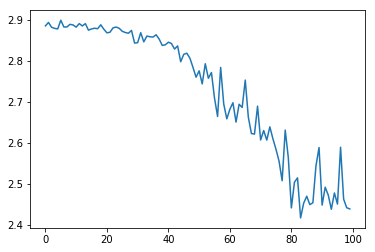

In [110]:
plt.plot(all_losses)

#### 在all_losses方面，增加更多的layers反而使loss下降的速度变慢, 需要更多的epoch去进行拟合, 反而效果没那么好, 在all_losses变化图上看, 增加更多的layers在epoch 60之后波动更大。

### 2. 将原始的RNN模型改成nn.LSTM和nn.GRU， 并且改变 `n_iters = 1000 ` 这个值，观察其变化

In [163]:
## 一层LSTM
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

rnn = nn.LSTM(n_letters, n_hidden) 

def train(category_tensor, line_tensor):

    hidden = (torch.zeros(1, n_hidden).view(1,1, -1), torch.zeros(1, n_hidden).view(1,1, -1))
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i].view(1,1, -1), hidden)

    loss = criterion(output[0], category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output[0], loss.item()


In [185]:
import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (0m 5s) 3.4993 Ajdrna / Chinese ✗ (Czech)
1000 10% (0m 10s) 3.5030 Gomes / Chinese ✗ (Portuguese)
1500 15% (0m 14s) 3.4957 Nguyen / Chinese ✗ (Vietnamese)
2000 20% (0m 19s) 3.4948 Macghabhann / Chinese ✗ (Irish)
2500 25% (0m 23s) 3.5003 Milionis / Chinese ✗ (Greek)
3000 30% (0m 27s) 3.4955 Numata / Korean ✗ (Japanese)
3500 35% (0m 32s) 3.4943 Slootmaekers / Korean ✗ (Dutch)
4000 40% (0m 37s) 3.4947 Gaspar / Korean ✗ (Spanish)
4500 45% (0m 42s) 3.4940 Santiago / Korean ✗ (Portuguese)
5000 50% (0m 47s) 3.4940 Kunisada / Korean ✗ (Japanese)
5500 55% (0m 52s) 3.4954 Sook / Korean ✓
6000 60% (0m 57s) 3.4941 Jirovy / Korean ✗ (Czech)
6500 65% (1m 1s) 3.4928 Wahner / Korean ✗ (German)
7000 70% (1m 6s) 3.4974 Wojda / Korean ✗ (Polish)
7500 75% (1m 10s) 3.4936 Shum / Korean ✗ (Chinese)
8000 80% (1m 15s) 3.4929 Santo / Korean ✗ (Japanese)
8500 85% (1m 20s) 3.4919 Ganim / Korean ✗ (Arabic)
9000 90% (1m 25s) 3.4931 Jordan / Korean ✗ (Polish)
9500 95% (1m 29s) 3.5195 Dasios / Korean ✗ (Greek

In [166]:
all_losses

[4.712336926460266,
 4.695747685432434,
 4.6869570255279545,
 4.658260760307312,
 4.658623356819152,
 4.6401368474960325,
 4.636119728088379,
 4.607329382896423,
 4.602596306800843,
 4.576643924713135,
 4.5732092905044555,
 4.5505405616760255,
 4.532009830474854,
 4.53022469997406,
 4.502360734939575,
 4.479867601394654,
 4.457614431381225,
 4.460269026756286,
 4.434601473808288,
 4.423415427207947,
 4.393729596138001,
 4.362393798828125,
 4.357750744819641,
 4.337530860900879,
 4.315607509613037,
 4.273849024772644,
 4.249654908180236,
 4.233464603424072,
 4.204136693477631,
 4.19838695526123,
 4.148013849258422,
 4.120276370048523,
 4.10782208442688,
 4.102773044109345,
 4.095934720039367,
 4.09167014837265,
 4.041359348297119,
 4.047734313011169,
 4.006619019508362,
 4.0008973383903506,
 3.9678905725479128,
 3.965552191734314,
 3.986646831035614,
 3.973888659477234,
 3.949313006401062,
 3.924298679828644,
 3.9310654067993163,
 3.91594037771225,
 3.8935810041427614,
 3.89898702144622

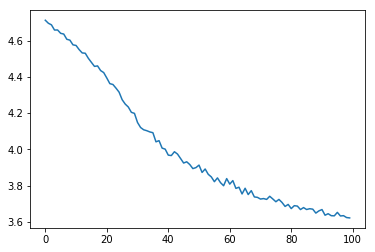

In [167]:
plt.plot(all_losses)

#### 使用一层LSTM相比于RNN模型, LSTM模型所造成的all_losses更大, 需要更长的epoch来进行拟合, 但从all_losses的变化趋势来看, 一层LSTM的all_losses变化趋势更稳定, LSTM并不是万能的, 在很多场景下也不太适用。

In [169]:
####### 两层LSTM
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

rnn = nn.LSTM(n_letters, n_hidden, 2) 

def train(category_tensor, line_tensor):

    hidden = (torch.zeros(2, 1, n_hidden), torch.zeros(2, 1, n_hidden))
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i].view(1,1, -1), hidden)

    loss = criterion(output[0], category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output[0], loss.item()


In [170]:
import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        

500 5% (0m 4s) 4.7876 Robert / Czech ✗ (French)
1000 10% (0m 9s) 4.7322 Schwenke / Czech ✗ (German)
1500 15% (0m 13s) 4.5783 Mcgregor / Portuguese ✗ (Scottish)
2000 20% (0m 18s) 4.5805 Protz / Greek ✗ (German)
2500 25% (0m 23s) 4.3909 Roosevelt / Greek ✗ (Dutch)
3000 30% (0m 28s) 4.4118 Bayer / Greek ✗ (German)
3500 35% (0m 32s) 4.1989 Greenberg / Greek ✗ (German)
4000 40% (0m 37s) 4.0832 Sekigawa / Greek ✗ (Japanese)
4500 45% (0m 42s) 3.8800 Kouretas / Greek ✓
5000 50% (0m 46s) 3.9053 Guillory / Greek ✗ (French)
5500 55% (0m 51s) 4.2102 Won / Arabic ✗ (Chinese)
6000 60% (0m 55s) 3.7594 Sutherland / Dutch ✗ (Scottish)
6500 65% (1m 0s) 3.7579 Voclain / Dutch ✗ (French)
7000 70% (1m 4s) 3.6919 Korycansky / Dutch ✗ (Czech)
7500 75% (1m 9s) 3.7413 Boden / Portuguese ✗ (English)
8000 80% (1m 13s) 3.6721 Albano / Dutch ✗ (Italian)
8500 85% (1m 18s) 3.7684 Dong / Vietnamese ✗ (Chinese)
9000 90% (1m 22s) 3.6197 Fraser / Portuguese ✗ (Scottish)
9500 95% (1m 27s) 3.9333 Mas / Vietnamese ✗ (Spani

In [171]:
all_losses

[4.854204802513123,
 4.8407377338409425,
 4.8261015462875365,
 4.808822984695435,
 4.798708710670471,
 4.778975105285644,
 4.768665189743042,
 4.757065925598145,
 4.739191594123841,
 4.722610960006714,
 4.712405953407288,
 4.686773076057434,
 4.68617166519165,
 4.661617722511291,
 4.643440322875977,
 4.63182228565216,
 4.614130449295044,
 4.605502257347107,
 4.568657307624817,
 4.560534882545471,
 4.5514861011505126,
 4.532289180755615,
 4.509602847099305,
 4.488746032714844,
 4.480935592651367,
 4.458853664398194,
 4.445205116271973,
 4.412596392631531,
 4.385676126480103,
 4.379089851379394,
 4.348655152320862,
 4.336476864814759,
 4.294292402267456,
 4.286288948059082,
 4.2526788854599,
 4.230871679782868,
 4.1810836458206175,
 4.197213203907013,
 4.174123506546021,
 4.141184101104736,
 4.118929135799408,
 4.065636057853698,
 4.061143925189972,
 4.0431366586685185,
 4.0352198910713195,
 4.04630152463913,
 4.0206491565704345,
 3.985143301486969,
 3.9626635551452636,
 3.96913202285766

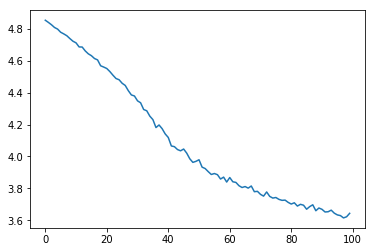

In [172]:
plt.plot(all_losses)

#### 后来试了两层的LSTM, 在all_losses方面跟一层的LSTM效果差不多, 进一步验证了LSTM并不一定适用于所有场景。

In [176]:
######### 一层GRU
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

rnn = nn.GRU(n_letters, n_hidden) 

def train(category_tensor, line_tensor):

    hidden = torch.zeros(1, n_hidden).view(1,1, -1)
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i].view(1,1, -1), hidden)

    loss = criterion(output[0], category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output[0], loss.item()

In [177]:
import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        

500 5% (0m 2s) 4.6888 An / Greek ✗ (Vietnamese)
1000 10% (0m 4s) 4.3569 Salazar / Irish ✗ (Spanish)
1500 15% (0m 6s) 4.2411 Egorihin / Irish ✗ (Russian)
2000 20% (0m 7s) 4.0928 Guan / Irish ✗ (Chinese)
2500 25% (0m 10s) 3.9152 Donati / Irish ✗ (Italian)
3000 30% (0m 12s) 3.7750 Delgado / Chinese ✗ (Portuguese)
3500 35% (0m 14s) 3.6630 Villalobos / German ✗ (Spanish)
4000 40% (0m 16s) 3.7048 Munro / Chinese ✗ (English)
4500 45% (0m 19s) 3.5659 Shinozuka / Chinese ✗ (Japanese)
5000 50% (0m 21s) 3.6346 Close / Chinese ✗ (Greek)
5500 55% (0m 23s) 3.5283 Geissler / Chinese ✗ (German)
6000 60% (0m 25s) 3.5744 Groel / Chinese ✗ (German)
6500 65% (0m 28s) 3.5080 Aeschelman / Chinese ✗ (German)
7000 70% (0m 30s) 3.5077 Valencia / Chinese ✗ (Spanish)
7500 75% (0m 32s) 3.5834 Thao / Chinese ✗ (Vietnamese)
8000 80% (0m 34s) 3.5362 Romao / Chinese ✗ (Portuguese)
8500 85% (0m 37s) 3.5031 Ramires / Chinese ✗ (Portuguese)
9000 90% (0m 39s) 3.9086 So / Korean ✓
9500 95% (0m 41s) 3.5003 Gagnier / Chines

In [179]:
all_losses

[4.837570972442627,
 4.8215248584747314,
 4.760647039413453,
 4.738818831443787,
 4.692070136070251,
 4.66250940322876,
 4.626874732971191,
 4.6000391435623165,
 4.55960165977478,
 4.4928178882598875,
 4.465303268432617,
 4.424322590827942,
 4.3717654418945315,
 4.311383681297302,
 4.252945818901062,
 4.24476758480072,
 4.186922464370728,
 4.151640603542328,
 4.103917593955994,
 4.079644644260407,
 4.025876233577728,
 4.00377495765686,
 4.020208475589752,
 3.959283299446106,
 3.9548675632476806,
 3.927812752723694,
 3.89632611989975,
 3.879806079864502,
 3.8633102560043335,
 3.850163471698761,
 3.8421720480918884,
 3.790863857269287,
 3.7928968548774717,
 3.767126657962799,
 3.7698105907440187,
 3.7567125129699708,
 3.7184891223907472,
 3.733848533630371,
 3.6909993052482606,
 3.703970282077789,
 3.6839227294921875,
 3.6755907368659972,
 3.665180835723877,
 3.6339398503303526,
 3.66661465883255,
 3.635739986896515,
 3.6423615789413453,
 3.638991105556488,
 3.6237839460372925,
 3.615389

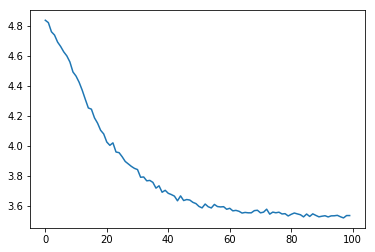

In [178]:
plt.plot(all_losses)

#### 一层GRU的效果跟LSTM差不多, 可能是GRU的参数相比于LSTM少, GRU的all_losses的收敛速度相比于LSTM更快。

In [180]:
########两层GRU
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

rnn = nn.GRU(n_letters, n_hidden, 2) 

def train(category_tensor, line_tensor):

    hidden = torch.zeros(2, 1, n_hidden)
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i].view(1,1, -1), hidden)

    loss = criterion(output[0], category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output[0], loss.item()


In [181]:
import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        

500 5% (0m 4s) 4.5598 Niall / French ✗ (Irish)
1000 10% (0m 8s) 4.0898 Petrezelka / English ✗ (Czech)
1500 15% (0m 13s) 3.9987 Lane / English ✗ (French)
2000 20% (0m 17s) 3.9764 Bei / Dutch ✗ (Chinese)
2500 25% (0m 21s) 3.6549 Koeman / Polish ✗ (Dutch)
3000 30% (0m 25s) 3.5688 Petersen / Polish ✗ (Czech)
3500 35% (0m 29s) 3.5271 Manoukarakis / Arabic ✗ (Greek)
4000 40% (0m 33s) 3.5184 O'Donnell / Chinese ✗ (Irish)
4500 45% (0m 37s) 3.5106 Anuprienko / Chinese ✗ (Russian)
5000 50% (0m 41s) 3.6436 Ngo / Korean ✗ (Vietnamese)
5500 55% (0m 45s) 3.5141 Devlin / Chinese ✗ (English)
6000 60% (0m 49s) 3.5126 Kunkel / Chinese ✗ (German)
6500 65% (0m 53s) 3.5078 Wilson / Chinese ✗ (Scottish)
7000 70% (0m 57s) 3.5748 Pae / Korean ✓
7500 75% (1m 2s) 3.4982 Jeltoukhov / Chinese ✗ (Russian)
8000 80% (1m 7s) 3.5425 Lobo / Korean ✗ (Spanish)
8500 85% (1m 11s) 3.7338 Ly / Korean ✗ (Vietnamese)
9000 90% (1m 17s) 3.4963 Rakhmilovich / Chinese ✗ (Russian)
9500 95% (1m 22s) 3.5048 Floss / Chinese ✗ (Englis

In [183]:
all_losses

[4.82769024848938,
 4.766834979057312,
 4.706433024406433,
 4.65922146320343,
 4.588628153800965,
 4.512042937278747,
 4.454999823570251,
 4.364158434867859,
 4.289035458564758,
 4.239190635681152,
 4.154955902099609,
 4.0978546667099,
 4.032416841983795,
 3.995419392585754,
 3.9497590708732604,
 3.913536925315857,
 3.8874288201332092,
 3.8476649951934814,
 3.82328405380249,
 3.8126294159889222,
 3.782908387184143,
 3.749604678153992,
 3.7335160040855406,
 3.6932683968544007,
 3.690850887298584,
 3.6787463140487673,
 3.6552116513252257,
 3.6442321968078613,
 3.6375628328323364,
 3.62863974571228,
 3.6127792835235595,
 3.6106207942962647,
 3.589759566783905,
 3.59663703918457,
 3.5795912098884584,
 3.5922521686553956,
 3.573165774345398,
 3.5710910296440126,
 3.570686149597168,
 3.567027542591095,
 3.572232737541199,
 3.5573303842544557,
 3.560799844264984,
 3.547358064651489,
 3.560123131275177,
 3.5418212723731997,
 3.5516788029670714,
 3.5432415127754213,
 3.536035904884338,
 3.54424

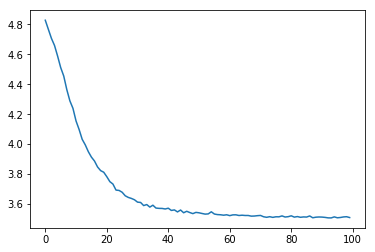

In [182]:
plt.plot(all_losses)

#### 两层GRU的效果跟一层GRU的效果差不多。更加验证GRU、LSTM并不是适用所有场景。

### 3. 把该RNN模型变成多层RNN模型，观察Loss的变化

In [184]:
#### 两层RNN模型
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2h1 = nn.Linear(output_size + hidden_size, hidden_size)

        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.i2o1 = nn.Linear(output_size + hidden_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        
        combined = torch.cat((output, hidden), 1)
        hidden = self.i2h1(combined)
        output = self.i2o1(combined)
        output = self.softmax(output)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


In [186]:
n_hidden = 128

rnn = RNN(n_letters, n_hidden, n_categories)

In [187]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()


In [188]:
import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        

500 5% (0m 1s) 3.4406 Barros / Arabic ✗ (Portuguese)
1000 10% (0m 3s) 3.9689 Rompaij / French ✗ (Dutch)
1500 15% (0m 5s) 2.2559 Gajos / Czech ✗ (Polish)
2000 20% (0m 7s) 3.3865 Toma / Dutch ✗ (Arabic)
2500 25% (0m 9s) 4.2300 Huan / Dutch ✗ (Chinese)
3000 30% (0m 10s) 2.6624 Sugita / Russian ✗ (Japanese)
3500 35% (0m 12s) 3.3059 Chau / Polish ✗ (Vietnamese)
4000 40% (0m 14s) 3.6354 Fontaine / Dutch ✗ (French)
4500 45% (0m 15s) 1.9723 Aloisi / Japanese ✗ (Italian)
5000 50% (0m 17s) 3.0424 Kefalas / Dutch ✗ (Greek)
5500 55% (0m 19s) 3.4675 Motoori / Dutch ✗ (Japanese)
6000 60% (0m 20s) 1.9110 Zharinov / French ✗ (Russian)
6500 65% (0m 22s) 3.0519 Wane / Russian ✗ (English)
7000 70% (0m 24s) 3.6820 Haik / Russian ✗ (Arabic)
7500 75% (0m 25s) 1.9210 You / Korean ✗ (Chinese)
8000 80% (0m 27s) 2.9073 Ha / Spanish ✗ (Vietnamese)
8500 85% (0m 29s) 2.8918 Silveira / Japanese ✗ (Portuguese)
9000 90% (0m 30s) 4.5045 Caron / Vietnamese ✗ (French)
9500 95% (0m 32s) 2.4711 Skomicka / Russian ✗ (Czech

In [189]:
all_losses

[3.1681564259529114,
 3.1356638300418855,
 3.1404507768154146,
 3.097662066221237,
 3.078721185922623,
 3.080066545009613,
 3.1361163651943205,
 3.0554616904258727,
 3.070012984275818,
 3.084433825016022,
 3.053752064704895,
 3.0371993374824524,
 3.050900837182999,
 3.0622640645503996,
 3.0910406363010408,
 3.121156430244446,
 3.0387837731838228,
 3.0585631012916563,
 3.007515993118286,
 3.010053355693817,
 2.9513913369178773,
 3.016290272474289,
 3.100942097902298,
 3.039082897901535,
 3.012818446159363,
 3.0112117433547976,
 3.0002832233905794,
 3.0441136050224302,
 3.049619411230087,
 2.9729437267780305,
 3.0016687726974487,
 2.9877519464492797,
 3.011382199525833,
 2.9368526577949523,
 2.9798224639892577,
 2.960586806535721,
 2.919096908569336,
 3.0078801357746126,
 2.903889330625534,
 2.9210276436805724,
 2.996527383327484,
 2.939090414047241,
 3.0030503737926484,
 2.9475463438034057,
 2.947841809988022,
 2.9947519731521606,
 2.888810887336731,
 2.9584113073349,
 2.931289205551147

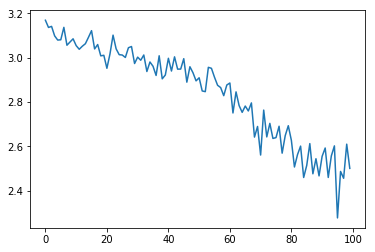

In [190]:
plt.plot(all_losses)

#### 两层RNN模型跟一层RNN模型相比, 在all_losses方面两层RNN模型需要更多的epoch来进行拟合, 在all_losses的变化方面，两层RNN模型的抖动程度更大, 变化趋势不稳定。

In [191]:
### 三层RNN模型
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2h1 = nn.Linear(output_size + hidden_size, hidden_size)

        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.i2o1 = nn.Linear(output_size + hidden_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        
        combined = torch.cat((output, hidden), 1)
        hidden = self.i2h1(combined)
        output = self.i2o1(combined)
        output = self.softmax(output)
        
        combined = torch.cat((output, hidden), 1)
        hidden = self.i2h1(combined)
        output = self.i2o1(combined)
        output = self.softmax(output)
    
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


In [192]:
n_hidden = 128

rnn = RNN(n_letters, n_hidden, n_categories)

In [193]:
import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        

500 5% (0m 2s) 3.1402 Tahan / Scottish ✗ (Arabic)
1000 10% (0m 5s) 3.4921 Tsucgimoto / Chinese ✗ (Japanese)
1500 15% (0m 7s) 3.1721 Trnkova / Korean ✗ (Czech)
2000 20% (0m 10s) 2.9709 Svejkovsky / Spanish ✗ (Czech)
2500 25% (0m 13s) 2.8675 Kikkert / Scottish ✗ (Dutch)
3000 30% (0m 16s) 3.4632 Gomatos / Dutch ✗ (Greek)
3500 35% (0m 19s) 2.8900 Williamson / German ✗ (Scottish)
4000 40% (0m 21s) 1.8284 Frangopoulos / Greek ✓
4500 45% (0m 24s) 3.0923 Pazyun / Scottish ✗ (Russian)
5000 50% (0m 27s) 3.1826 Duncan / German ✗ (Scottish)
5500 55% (0m 30s) 2.5226 Lavoie / Vietnamese ✗ (French)
6000 60% (0m 32s) 1.8061 Antimisiaris / Greek ✓
6500 65% (0m 35s) 2.9594 Ngo / Chinese ✗ (Vietnamese)
7000 70% (0m 38s) 2.1004 Araujo / Spanish ✓
7500 75% (0m 40s) 3.1092 Junge / French ✗ (German)
8000 80% (0m 43s) 5.2397 Gajos / Greek ✗ (Polish)
8500 85% (0m 45s) 3.1451 Hana / Japanese ✗ (Czech)
9000 90% (0m 48s) 3.0487 Casales / English ✗ (Spanish)
9500 95% (0m 50s) 1.0909 Lolos / Greek ✓
10000 100% (0m 

In [194]:
all_losses

[3.162571839094162,
 3.134050186872482,
 3.1017333018779754,
 3.093256251215935,
 3.0919903600215912,
 3.137398899793625,
 3.075669184923172,
 3.0998519396781923,
 3.0824657583236696,
 3.102563799619675,
 3.1100588142871857,
 3.106146149635315,
 3.0211273717880247,
 3.0230233585834503,
 3.073580070734024,
 2.974420348405838,
 3.0609250223636626,
 3.0434558326005936,
 3.010377985239029,
 3.0687682890892027,
 3.058106061220169,
 3.0123681199550627,
 3.0085936963558195,
 3.021371328830719,
 3.0627679193019866,
 2.9921584141254427,
 3.027936165332794,
 2.9879233717918394,
 3.019032419919968,
 3.0097618436813356,
 2.980289262533188,
 2.9934946703910827,
 2.9894834852218626,
 2.9906234776973726,
 2.9701323676109315,
 2.9959412360191346,
 2.9880495929718016,
 2.932204484939575,
 2.9625630366802214,
 2.954984701871872,
 2.9829032719135284,
 2.9637342166900633,
 2.9425945925712584,
 2.992256615161896,
 2.951697838306427,
 2.93788885474205,
 2.8924527776241304,
 2.9014368772506716,
 2.8858748495

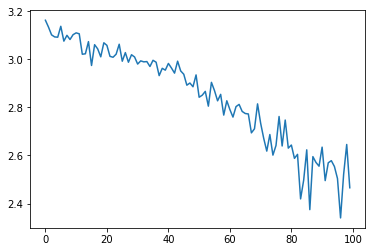

In [195]:
plt.plot(all_losses)

#### 三层RNN模型跟两层RNN模型效果差不多。

### 4. Pytorch里边常用nn.NLLoss来代替crossentropy，将criterion改为nn.NLLoss，观察变化

In [196]:
### RNN模型
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


In [197]:
n_hidden = 128

rnn = RNN(n_letters, n_hidden, n_categories)

In [203]:
criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [204]:
import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0       
 

500 5% (0m 0s) 2.7277 Bencivenni / Italian ✓
1000 10% (0m 1s) 2.8397 Bakhrakh / Portuguese ✗ (Russian)
1500 15% (0m 2s) 2.5792 Abbadelli / Italian ✓
2000 20% (0m 3s) 2.8175 Jasso / Czech ✗ (Spanish)
2500 25% (0m 4s) 2.6129 Hara / Japanese ✓
3000 30% (0m 5s) 2.1507 Malihoudis / Greek ✓
3500 35% (0m 6s) 2.3653 Tagawa / Japanese ✓
4000 40% (0m 7s) 2.5424 Delgado / Portuguese ✓
4500 45% (0m 8s) 2.2087 Hamatnurov / Russian ✓
5000 50% (0m 9s) 2.5464 Crawford / Scottish ✓
5500 55% (0m 9s) 2.7038 Scutese / German ✗ (Italian)
6000 60% (0m 10s) 2.7157 Nifterick / Polish ✗ (Dutch)
6500 65% (0m 11s) 2.1777 Chu / Chinese ✗ (Vietnamese)
7000 70% (0m 12s) 0.8286 Moraitopoulos / Greek ✓
7500 75% (0m 13s) 2.4927 Mcgregor / Russian ✗ (Scottish)
8000 80% (0m 14s) 1.9909 Andrysiak / Polish ✓
8500 85% (0m 15s) 2.6573 Trieu / Spanish ✗ (Vietnamese)
9000 90% (0m 16s) 2.7549 OuYang / Japanese ✗ (Chinese)
9500 95% (0m 18s) 1.9981 Mikhalchenko / Russian ✓
10000 100% (0m 18s) 1.6887 Langenberg / Dutch ✗ (German)

In [205]:
all_losses

[2.8980377674102784,
 2.8898485469818116,
 2.878171525001526,
 2.8818750524520875,
 2.8652445912361144,
 2.8811440014839174,
 2.8591758227348327,
 2.844473433494568,
 2.8567240953445436,
 2.8536628890037536,
 2.8541152334213256,
 2.8388098287582397,
 2.8394432139396666,
 2.833866844177246,
 2.822354996204376,
 2.8496865606307984,
 2.8195125675201416,
 2.8252422332763674,
 2.8269048643112185,
 2.8327781844139097,
 2.801860475540161,
 2.800364816188812,
 2.796776838302612,
 2.7685921001434326,
 2.7895255088806152,
 2.7808701491355894,
 2.7553528928756714,
 2.775154674053192,
 2.798869330883026,
 2.759698896408081,
 2.791500601768494,
 2.7821022200584413,
 2.7441909408569334,
 2.741877510547638,
 2.7219219970703126,
 2.7329411125183105,
 2.7942855954170227,
 2.7218575501441955,
 2.744114487171173,
 2.739003829956055,
 2.736093072891235,
 2.705316417217255,
 2.6722927951812743,
 2.7075550031661986,
 2.675313992500305,
 2.642425616979599,
 2.694054979085922,
 2.7025330877304077,
 2.65887462

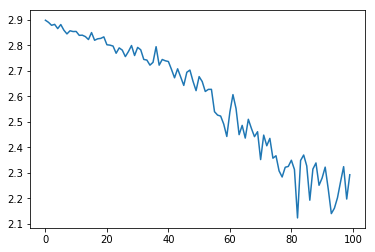

In [206]:
plt.plot(all_losses)

#### 使用nn.NLLLoss代替nn.crossentropy后, 在all_losses方面两者跟之前的变化不大, 但是替换后预测的准确度确提升了(最明显的就是打钩的地方多了！)。

500 5% (0m 2s) 2.7701 Crespo / Irish ✗ (Spanish)
1000 10% (0m 4s) 2.9211 Wechsler / Korean ✗ (German)
1500 15% (0m 6s) 2.7147 Antonopoulos / Greek ✓
2000 20% (0m 8s) 2.8491 Duerr / Chinese ✗ (German)
2500 25% (0m 10s) 3.0066 Ryusaki / Chinese ✗ (Japanese)
3000 30% (0m 12s) 2.8041 Zamorano / Chinese ✗ (Spanish)
3500 35% (0m 14s) 2.8145 Pellegrino / Vietnamese ✗ (Italian)
4000 40% (0m 16s) 2.7891 Than / Irish ✗ (Vietnamese)
4500 45% (0m 18s) 3.1462 De leon / Irish ✗ (Spanish)
5000 50% (0m 20s) 2.8580 La / Japanese ✗ (Vietnamese)
5500 55% (0m 23s) 2.6879 Luu / Vietnamese ✓
6000 60% (0m 25s) 3.1966 Albuquerque / Irish ✗ (Portuguese)
6500 65% (0m 27s) 2.5489 Song / Italian ✗ (Korean)
7000 70% (0m 29s) 2.5324 Jarikhin / Irish ✗ (Russian)
7500 75% (0m 31s) 0.7089 Grammatakakis / Greek ✓
8000 80% (0m 34s) 2.9483 Althuis / Greek ✗ (Dutch)
8500 85% (0m 36s) 2.4779 Eckstein / Irish ✗ (German)
9000 90% (0m 38s) 2.1151 Schnoor / German ✓
9500 95% (0m 40s) 2.8379 Hanraets / Greek ✗ (Dutch)
10000 100

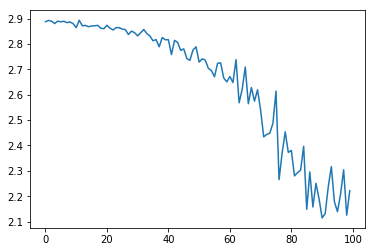

In [210]:
###############################################################
##添加两层layers
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h1 = nn.Linear(input_size + hidden_size, hidden_size*2)
        self.i2h2 = nn.Linear(hidden_size*2, hidden_size)
        
        self.i2o1 = nn.Linear(input_size + hidden_size, hidden_size*2)
        self.i2o2 = nn.Linear(hidden_size*2, hidden_size)
        self.i2o3 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h1(combined)
        hidden = self.i2h2(hidden)
        
        output = self.i2o1(combined)
        output = self.i2o2(output)
        output = self.i2o3(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


n_hidden = 128

rnn = RNN(n_letters, n_hidden, n_categories)



import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


all_losses

plt.plot(all_losses)

#### 使用nn.NLLLoss代替nn.crossentropy后, 在all_losses方面跟之前的变化不大。

500 5% (0m 3s) 2.8894 Haanrade / Vietnamese ✗ (Dutch)
1000 10% (0m 7s) 2.8545 Roijacker / Vietnamese ✗ (Dutch)
1500 15% (0m 11s) 2.8496 Forbes / Greek ✗ (English)
2000 20% (0m 15s) 2.7087 Alamanni / Italian ✓
2500 25% (0m 19s) 2.8718 Bukowski / Italian ✗ (Polish)
3000 30% (0m 23s) 2.8746 Prehatney / English ✗ (Czech)
3500 35% (0m 27s) 2.8525 Sneijer / Vietnamese ✗ (Dutch)
4000 40% (0m 30s) 2.8065 Mikolajczak / Vietnamese ✗ (Polish)
4500 45% (0m 34s) 2.7816 Oh  / Korean ✓
5000 50% (0m 38s) 2.9346 Antwerp / Scottish ✗ (Dutch)
5500 55% (0m 42s) 2.7922 Reilly / English ✗ (Irish)
6000 60% (0m 46s) 2.9852 Oh  / Russian ✗ (Korean)
6500 65% (0m 49s) 2.3270 Umehara / Italian ✗ (Japanese)
7000 70% (0m 53s) 2.3006 Cassano / Japanese ✗ (Italian)
7500 75% (0m 57s) 2.4574 Pain / Irish ✗ (Russian)
8000 80% (1m 0s) 2.2108 Coghlan / Irish ✓
8500 85% (1m 4s) 2.7302 Rujitsky / French ✗ (Russian)
9000 90% (1m 8s) 2.6838 Shi / Italian ✗ (Chinese)
9500 95% (1m 12s) 2.7015 Cho / Italian ✗ (Korean)
10000 100%

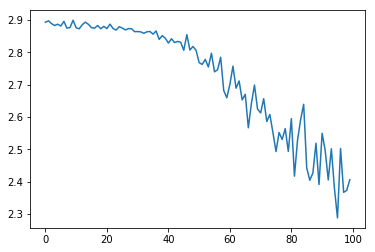

In [211]:
#########添加三层layers

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h1 = nn.Linear(input_size + hidden_size, hidden_size*3)
        self.i2h2 = nn.Linear(hidden_size*3, hidden_size*2)
        self.i2h3 = nn.Linear(hidden_size*2, hidden_size)
        
        self.i2o1 = nn.Linear(input_size + hidden_size, hidden_size*3)
        self.i2o2 = nn.Linear(hidden_size*3, hidden_size*2)
        self.i2o3 = nn.Linear(hidden_size*2, hidden_size)
        self.i2o4 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h1(combined)
        hidden = self.i2h2(hidden)
        hidden = self.i2h3(hidden)
        
        output = self.i2o1(combined)
        output = self.i2o2(output)
        output = self.i2o3(output)
        output = self.i2o4(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)



n_hidden = 128

rnn = RNN(n_letters, n_hidden, n_categories)



import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


all_losses

plt.plot(all_losses)

#### 使用nn.NLLLoss代替nn.crossentropy后, 在all_losses方面跟之前的变化不大。

500 5% (0m 2s) -0.0593 Hung / Dutch ✗ (Korean)
1000 10% (0m 4s) -0.1331 Wawrzaszek / Portuguese ✗ (Polish)
1500 15% (0m 7s) -0.2762 Thurling / Dutch ✗ (English)
2000 20% (0m 9s) -0.2923 Sitko / Dutch ✗ (Polish)
2500 25% (0m 12s) -0.4434 Tillett / Irish ✗ (English)
3000 30% (0m 14s) -0.4370 Rahal / Irish ✗ (Arabic)
3500 35% (0m 17s) -0.5754 Levesque / Irish ✗ (French)
4000 40% (0m 20s) -0.4323 Yoo / Portuguese ✗ (Korean)
4500 45% (0m 22s) -0.8387 Houten / Irish ✗ (Dutch)
5000 50% (0m 24s) -0.6260 Zhui / English ✗ (Chinese)
5500 55% (0m 27s) -0.9075 Moreno / German ✗ (Spanish)
6000 60% (0m 29s) -0.9288 Gibson / Irish ✗ (Scottish)
6500 65% (0m 32s) -0.9128 Sobol / German ✗ (Polish)
7000 70% (0m 34s) -0.7315 Oh  / Dutch ✗ (Korean)
7500 75% (0m 37s) -0.9611 Zuniga / German ✗ (Spanish)
8000 80% (0m 40s) -0.9755 Bleskan / Irish ✗ (Czech)
8500 85% (0m 42s) -0.9780 Wickham / Irish ✗ (English)
9000 90% (0m 45s) -0.9800 Szwedko / German ✗ (Polish)
9500 95% (0m 48s) -0.9818 Bakotin / Irish ✗ (Russ

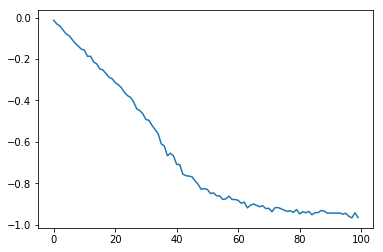

In [212]:
##########LSTM、GRU
########一层LSTM
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

rnn = nn.LSTM(n_letters, n_hidden) 
criterion = nn.NLLLoss()
def train(category_tensor, line_tensor):

    hidden = (torch.zeros(1, n_hidden).view(1,1, -1), torch.zeros(1, n_hidden).view(1,1, -1))
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i].view(1,1, -1), hidden)

    loss = criterion(output[0], category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output[0], loss.item()


import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

all_losses

plt.plot(all_losses)      

#### 使用nn.NLLLoss代替nn.crossentropy后, 在all_losses方面跟之前的变化不大。

500 5% (0m 4s) -0.1262 Sierzant / Japanese ✗ (Polish)
1000 10% (0m 10s) -0.1033 Bei / Polish ✗ (Chinese)
1500 15% (0m 14s) -0.2161 Jon / Russian ✗ (Korean)
2000 20% (0m 20s) -0.3904 Warwick / Russian ✗ (English)
2500 25% (0m 25s) -0.3216 Cameron / Russian ✗ (Scottish)
3000 30% (0m 30s) -0.5060 Lohrenz / Russian ✗ (German)
3500 35% (0m 35s) -0.7436 Hanania / Russian ✗ (Arabic)
4000 40% (0m 40s) -0.7230 Araujo / Russian ✗ (Portuguese)
4500 45% (0m 45s) -0.8669 Oirschot / Russian ✗ (Dutch)
5000 50% (0m 50s) -0.9124 Basov / Russian ✓
5500 55% (0m 55s) -0.8517 Burns / Russian ✗ (Scottish)
6000 60% (1m 0s) -0.8762 Cham / Russian ✗ (Arabic)
6500 65% (1m 6s) -0.9727 Sawamura / Russian ✗ (Japanese)
7000 70% (1m 11s) -0.9748 Abbadelli / Russian ✗ (Italian)
7500 75% (1m 16s) -0.9566 Hughes / Russian ✗ (Scottish)
8000 80% (1m 20s) -0.9226 Haik / Korean ✗ (Arabic)
8500 85% (1m 25s) -0.8556 Chu / Korean ✗ (Chinese)
9000 90% (1m 30s) -0.8699 Gil / Korean ✓
9500 95% (1m 35s) -0.9861 Salazar / Chinese 

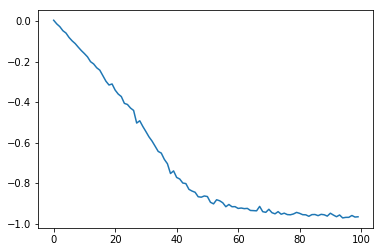

In [213]:
######两层LSTM
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

rnn = nn.LSTM(n_letters, n_hidden, 2) 

criterion = nn.NLLLoss()

def train(category_tensor, line_tensor):

    hidden = (torch.zeros(2, 1, n_hidden), torch.zeros(2, 1, n_hidden))
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i].view(1,1, -1), hidden)

    loss = criterion(output[0], category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output[0], loss.item()

        
import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

all_losses

plt.plot(all_losses)

#### 使用nn.NLLLoss代替nn.crossentropy后, 在all_losses方面之前的变化不大。

500 5% (0m 1s) -0.1478 Woo / Portuguese ✗ (Chinese)
1000 10% (0m 3s) -0.3329 Frost / Polish ✗ (German)
1500 15% (0m 5s) -0.5960 Chong / Czech ✗ (Chinese)
2000 20% (0m 7s) -0.9588 Calogerakis / Polish ✗ (Greek)
2500 25% (0m 9s) -0.9628 Dritsas / Czech ✗ (Greek)
3000 30% (0m 11s) -0.9635 Liatos / Czech ✗ (Greek)
3500 35% (0m 13s) -0.7652 Ina / Korean ✗ (Japanese)
4000 40% (0m 15s) -0.9737 Finke / Korean ✗ (Czech)
4500 45% (0m 17s) -0.9951 Iturburua / Korean ✗ (Spanish)
5000 50% (0m 19s) -0.9767 Felix / Korean ✗ (Spanish)
5500 55% (0m 21s) -0.9786 Fionn / Korean ✗ (Irish)
6000 60% (0m 23s) -0.9957 Plourde / Korean ✗ (French)
6500 65% (0m 25s) -0.9807 Brant / Korean ✗ (German)
7000 70% (0m 26s) -0.8647 Eda / Chinese ✗ (Japanese)
7500 75% (0m 29s) -0.9950 Barros / Korean ✗ (Portuguese)
8000 80% (0m 31s) -0.9979 Timberlake / Korean ✗ (English)
8500 85% (0m 33s) -0.9738 Lawa / Chinese ✗ (Czech)
9000 90% (0m 35s) -0.9924 Wasem / Korean ✗ (Arabic)
9500 95% (0m 37s) -0.9978 Coilean / Korean ✗ (I

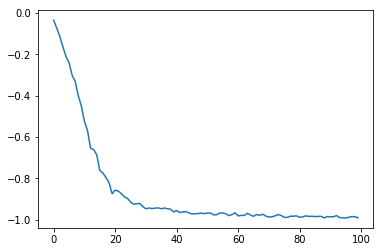

In [214]:
#######一层GRU
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

rnn = nn.GRU(n_letters, n_hidden) 

criterion = nn.NLLLoss()

def train(category_tensor, line_tensor):

    hidden = torch.zeros(1, n_hidden).view(1,1, -1)
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i].view(1,1, -1), hidden)

    loss = criterion(output[0], category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output[0], loss.item()



import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0



all_losses

plt.plot(all_losses)

#### 使用nn.NLLLoss代替nn.crossentropy后, 在all_losses方面跟之前的变化不大。

500 5% (0m 3s) -0.1566 Ta / Greek ✗ (Vietnamese)
1000 10% (0m 7s) -0.7330 Jaskolski / Greek ✗ (Polish)
1500 15% (0m 11s) -0.7885 Phan / Chinese ✗ (Vietnamese)
2000 20% (0m 15s) -0.7644 Ron / Chinese ✗ (Korean)
2500 25% (0m 19s) -0.8393 Woo / Chinese ✗ (Korean)
3000 30% (0m 23s) -0.9902 Connell / Chinese ✗ (Irish)
3500 35% (0m 27s) -0.9903 Cardona / Chinese ✗ (Spanish)
4000 40% (0m 31s) -0.9970 Lieberenz / Chinese ✗ (German)
4500 45% (0m 35s) -0.9935 Earing / Chinese ✗ (English)
5000 50% (0m 39s) -0.9968 Nemecek / Chinese ✗ (Czech)
5500 55% (0m 43s) -0.9956 Hajjar / Chinese ✗ (Arabic)
6000 60% (0m 46s) -0.9904 Breda / Chinese ✗ (Italian)
6500 65% (0m 50s) -0.9728 Luc / Vietnamese ✓
7000 70% (0m 54s) -0.9985 Ramires / Chinese ✗ (Portuguese)
7500 75% (0m 58s) -0.9928 Nunes / Chinese ✗ (Portuguese)
8000 80% (1m 2s) -0.9970 Pelaez / Chinese ✗ (Spanish)
8500 85% (1m 6s) -0.9956 Breda / Chinese ✗ (Dutch)
9000 90% (1m 10s) -0.9996 Von wegberg / Chinese ✗ (German)
9500 95% (1m 14s) -0.9827 Sala

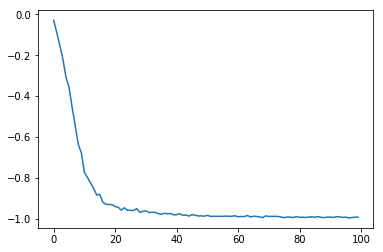

In [215]:
####### 两层GUR
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

rnn = nn.GRU(n_letters, n_hidden, 2) 
criterion = nn.NLLLoss()

def train(category_tensor, line_tensor):

    hidden = torch.zeros(2, 1, n_hidden)
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i].view(1,1, -1), hidden)

    loss = criterion(output[0], category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output[0], loss.item()


import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

        
all_losses

plt.plot(all_losses)

#### 使用nn.NLLLoss代替nn.crossentropy后, 在all_losses方面跟之前的变化不大。

500 5% (0m 1s) 2.6811 Pae / Vietnamese ✗ (Korean)
1000 10% (0m 3s) 3.4905 Quraishi / Russian ✗ (Arabic)
1500 15% (0m 5s) 2.7151 Verona / Portuguese ✗ (Italian)
2000 20% (0m 7s) 4.1992 Garb / Dutch ✗ (German)
2500 25% (0m 8s) 3.1381 Lew / Irish ✗ (Chinese)
3000 30% (0m 10s) 3.5957 Hanek / German ✗ (Czech)
3500 35% (0m 11s) 3.7793 Colman / Scottish ✗ (Irish)
4000 40% (0m 13s) 2.4415 Belo / Irish ✗ (Portuguese)
4500 45% (0m 15s) 3.7235 Thuy / English ✗ (Vietnamese)
5000 50% (0m 16s) 3.7101 Hughes / Greek ✗ (Scottish)
5500 55% (0m 18s) 3.4960 Albert / Spanish ✗ (French)
6000 60% (0m 19s) 2.3511 Maolmhuaidh / English ✗ (Irish)
6500 65% (0m 21s) 2.4955 Teague / Arabic ✗ (Irish)
7000 70% (0m 22s) 4.4926 Adamo / German ✗ (Italian)
7500 75% (0m 24s) 0.4094 Koustoubos / Greek ✓
8000 80% (0m 25s) 2.9732 Zavala / Italian ✗ (Spanish)
8500 85% (0m 27s) 2.9421 Janacek / Irish ✗ (Czech)
9000 90% (0m 29s) 3.2630 Jenin / Irish ✗ (Russian)
9500 95% (0m 31s) 5.7136 Close / French ✗ (Greek)
10000 100% (0m 

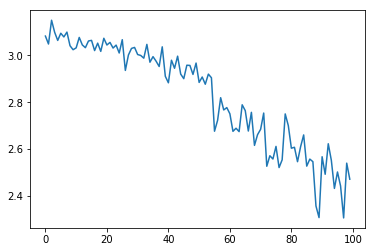

In [216]:
##########两层RNN模型，
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2h1 = nn.Linear(output_size + hidden_size, hidden_size)

        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.i2o1 = nn.Linear(output_size + hidden_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        
        combined = torch.cat((output, hidden), 1)
        hidden = self.i2h1(combined)
        output = self.i2o1(combined)
        output = self.softmax(output)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


n_hidden = 128

rnn = RNN(n_letters, n_hidden, n_categories)

criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()


import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


all_losses

plt.plot(all_losses)

#### 使用nn.NLLLoss代替nn.crossentropy后, 在all_losses方面跟之前的变化不大。

500 5% (0m 2s) 2.6601 Broz / Portuguese ✗ (Polish)
1000 10% (0m 5s) 2.7366 Kwang  / German ✗ (Korean)
1500 15% (0m 7s) 2.8490 Sloan / Scottish ✗ (Irish)
2000 20% (0m 9s) 2.9704 Kafka / German ✗ (Czech)
2500 25% (0m 11s) 3.0503 Koury / Portuguese ✗ (Arabic)
3000 30% (0m 14s) 2.8208 Kennedy / Czech ✗ (Scottish)
3500 35% (0m 16s) 3.2902 Protopsaltis / Scottish ✗ (Greek)
4000 40% (0m 18s) 2.8186 Varvitsiotes / Japanese ✗ (Greek)
4500 45% (0m 21s) 3.0756 Faolan / English ✗ (Irish)
5000 50% (0m 23s) 2.6663 Mitchell / Czech ✗ (English)
5500 55% (0m 25s) 2.6164 Paredes / Korean ✗ (Portuguese)
6000 60% (0m 28s) 2.9227 Jiu / Italian ✗ (Chinese)
6500 65% (0m 30s) 2.4362 Tuma / Spanish ✗ (Arabic)
7000 70% (0m 32s) 2.6354 Mckay / German ✗ (Scottish)
7500 75% (0m 34s) 3.1637 Ferreiro / Japanese ✗ (Portuguese)
8000 80% (0m 37s) 2.6694 Kennedy / French ✗ (Scottish)
8500 85% (0m 39s) 4.2695 Sen / English ✗ (Japanese)
9000 90% (0m 41s) 2.3399 Suh / German ✗ (Korean)
9500 95% (0m 43s) 2.6582 Paredes / Po

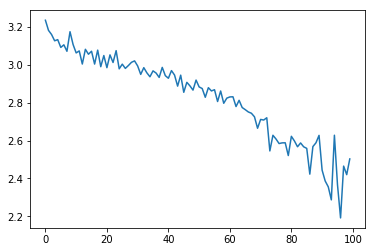

In [217]:
#########多层RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2h1 = nn.Linear(output_size + hidden_size, hidden_size)

        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.i2o1 = nn.Linear(output_size + hidden_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        
        combined = torch.cat((output, hidden), 1)
        hidden = self.i2h1(combined)
        output = self.i2o1(combined)
        output = self.softmax(output)
        
        combined = torch.cat((output, hidden), 1)
        hidden = self.i2h1(combined)
        output = self.i2o1(combined)
        output = self.softmax(output)
    
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

    
n_hidden = 128

rnn = RNN(n_letters, n_hidden, n_categories)


import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


all_losses

plt.plot(all_losses)

#### 使用nn.NLLLoss代替nn.crossentropy后, 在all_losses方面跟之前的变化不大。